In [18]:
from neural_astar_jax.utils import data
from neural_astar_jax.utils import training
import matplotlib.pyplot as plt
import jax
from importlib import reload
from neural_astar_jax.planner import astar, differentiable_astar
reload(data)
reload(training)
reload(differentiable_astar)
reload(astar)
import optax
from flax.training.train_state import TrainState

In [2]:
dataloader = data.MazeDataLoader(filename="../../planning-datasets/data/mpd/bugtrap_forest_032_moore_c8.npz", split="train", batch_size=100)
batch = dataloader.sample_batch(jax.random.PRNGKey(0))

In [8]:
planner = astar.NeuralAstar(is_training=True, search_step_ratio=0.25)
variables = planner.init(jax.random.PRNGKey(0), batch.map_design, batch.start_map, batch.goal_map)

In [9]:
class TrainStateBN(TrainState):
    batch_stats: dict

state = TrainStateBN.create(apply_fn=planner.apply, params=variables["params"], batch_stats=variables["batch_stats"], tx=optax.rmsprop(learning_rate=0.001))


In [ ]:
key = jax.random.PRNGKey(0)
for i in range(32):
    key1, key = jax.random.split(key)
    batch = dataloader.sample_batch(key1)
    %time loss, state, outputs, updates = training.step(batch, state, True)
    print(loss)

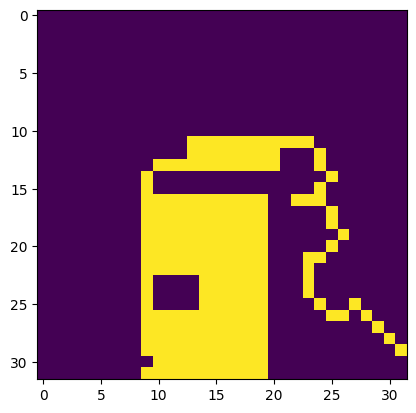

In [12]:
plt.imshow(outputs.history[2])